<a href="https://colab.research.google.com/github/Olesiewitch/Predictive_Analytics/blob/master/Uplift_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Uplift Application**

This notebook includes:
* Exploratory Data Analysis
* Application in CausalML
* Application in Pylift
* Application in DoWhy


##**Loading required packages**



In [1]:
# Main imports 

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})


# imports for Causalml
!pip install causalml
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain
from causalml.metrics import plot,auuc_score
from sklearn.model_selection import train_test_split

# import for Uplifttree visualization -Causalml
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image, display


# imports for PyLift
!pip install pylift
from pylift import TransformedOutcome
pd.set_option('display.max_colwidth', None)

# imports for DoWhy
!pip install dowhy
import dowhy
from dowhy import CausalModel
from networkx.drawing.nx_pydot import to_pydot


from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 3.9MB 2.7MB/s 
     |████████████████████████████████| 276kB 19.2MB/s 
     |████████████████████████████████| 1.8MB 27.3MB/s 
  Created wheel for causalml: filename=causalml-0.8.0-cp36-cp36m-linux_x86_64.whl size=482050 sha256=669dfa1e449b9efa97494278fc561267bd870947ee03aaff74a569a06b736719
  Stored in directory: /root/.cache/pip/wheels/db/d8/1f/c5c57e0a0a1e2d597da3b4b73f26a0365874e363bb1b57db41
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394114 sha256=64726fc3c0f5d2ddd443e966506c67d1d49d290df8a11714a50b5553a083fc2b
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built causalml shap


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 81kB 3.2MB/s 
  Created wheel for pylift: filename=pylift-0.1.5-cp36-none-any.whl size=26030 sha256=5fae5ea09cf62df0f64e3ea3934cbbc6320b1cabde8be05a4a85e55629049859
  Stored in directory: /root/.cache/pip/wheels/b3/71/23/2587db6f475f0abec88ac2a48dbcf990df7502df94435a8569
Successfully built pylift
     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 5.8MB 7.7MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1
  Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


##**Explanatory data analysis**

In [2]:
# Read data
dataurl='https://raw.githubusercontent.com/Olesiewitch/Predictive_Analytics/master/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv'
df=pd.read_csv(dataurl)
df.head()


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


###**Univariate Distribution**

Categorical variable



In [ ]:
# Inspect Target Variable
# Target variable - spend

target=df['spend']
non_zero = target[target !=0].shape[0]
print("{}% - of samples actually spent". format(100 * non_zero / target.shape[0]))


0.903125% - of samples actually spent


From above observation, considering that the conversion rate and actual purchase rate are very small. We use **'Visit'** as our treatment effect outcome target here. (i.e we measure the effect of email campaign via if the customer visited the website or not)

In [ ]:
df.groupby("visit").mean()


,recency,history,mens,womens,newbie,conversion,spend
visit,,,,,,,
0,5.872505,235.163403,0.549647,0.538988,0.517580,0.000000,0.00000
1,5.131467,282.323739,0.559080,0.612093,0.413136,0.061529,7.15969


**Numeric Variables**

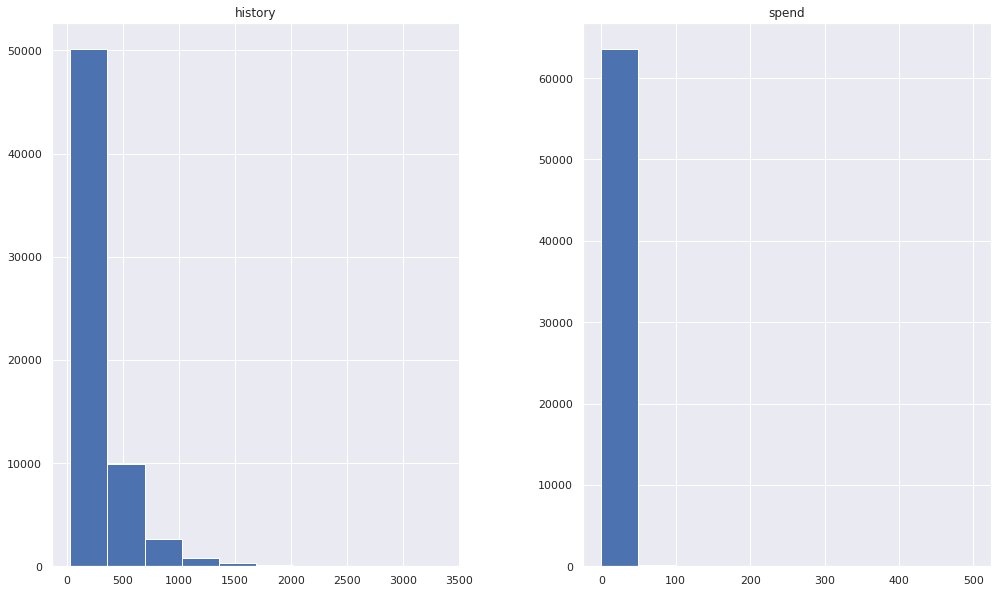

In [ ]:
df.select_dtypes(include='float64').hist();

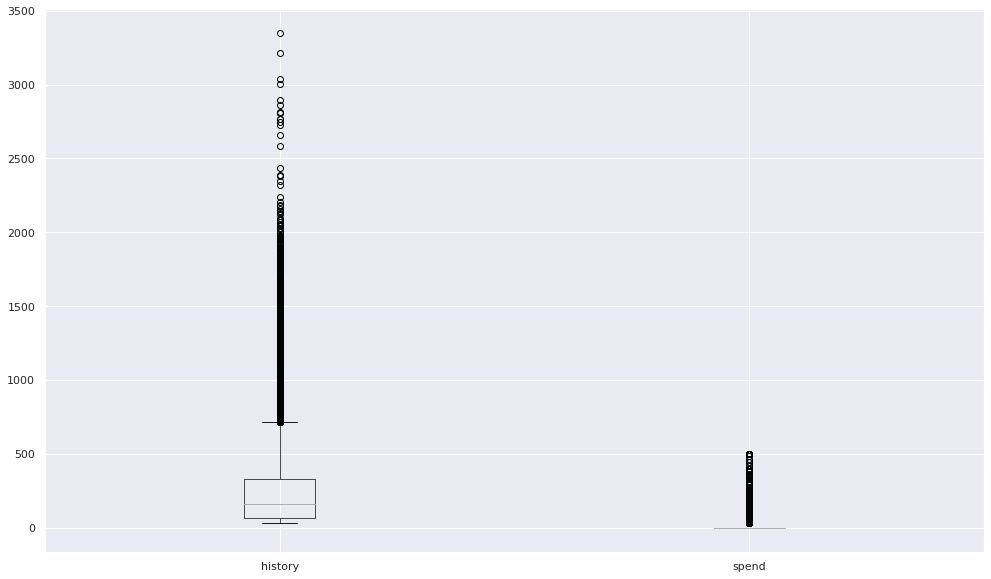

In [ ]:
df.boxplot(column=list(df.select_dtypes(include='float64')));

**Multivariate distribution**

First, we have a glance at how variable 'Segment' (the treatment assignment) is lined to the target variable, and other feature variables. From the distribution plots below, its clear that consumers in Mens, Womens campaign and No campaign groups were almost perfectly random chosen. There are almost equal amount of people with the same features in treatment assignment groups, which ensures there is no selection bias. 

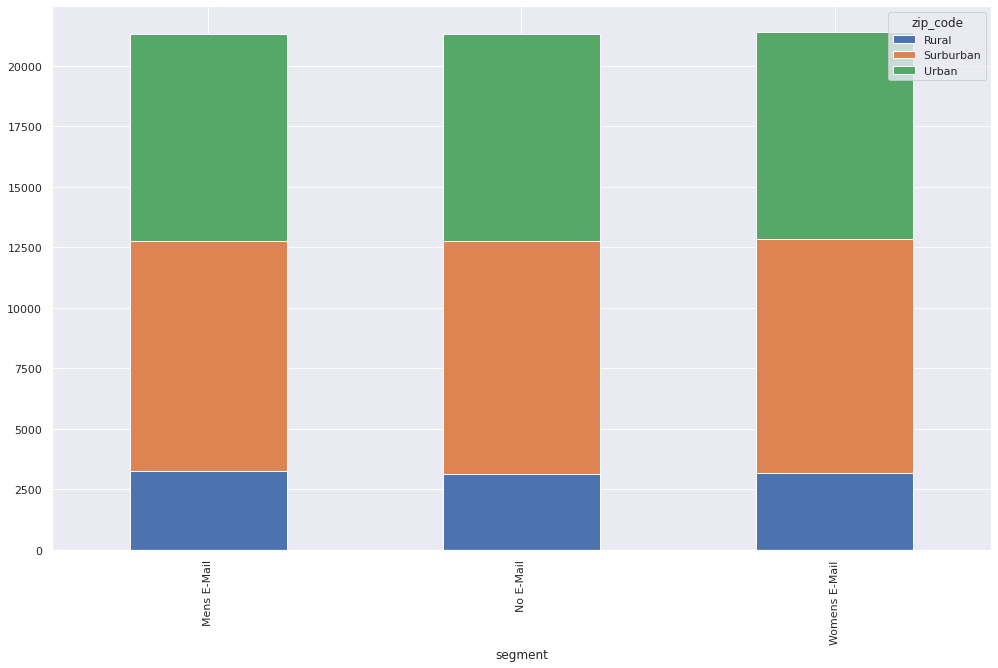

In [ ]:
segment_zip=df.groupby(['zip_code','segment']).size().reset_index().pivot(columns ='zip_code', index='segment', values=0)
segment_zip.plot(kind='bar', stacked=True,);

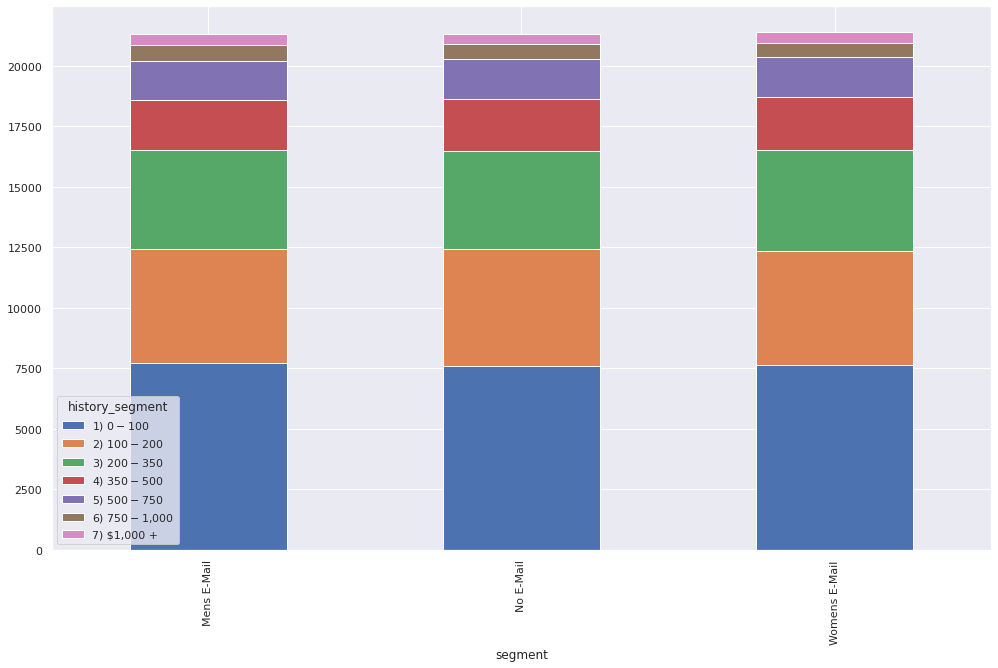

In [ ]:
segment_hist=df.groupby(['history_segment','segment']).size().reset_index().pivot(columns ='history_segment', index='segment', values=0)
segment_hist.plot(kind='bar', stacked=True);


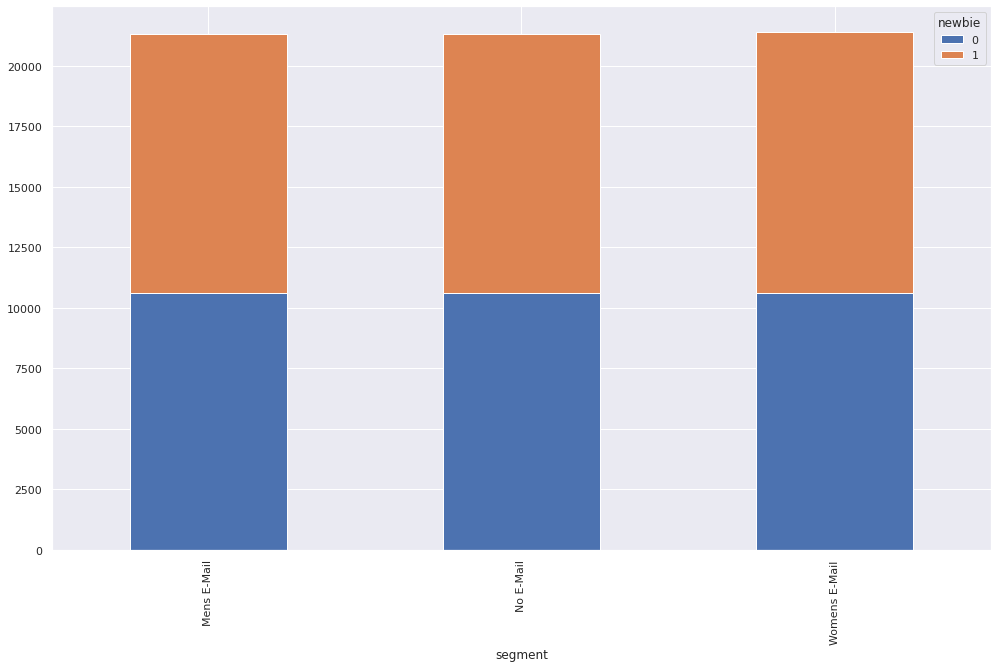

In [ ]:
segment_newbie=df.groupby(['newbie','segment']).size().reset_index().pivot(columns ='newbie', index='segment', values=0)
segment_newbie.plot(kind='bar', stacked=True);

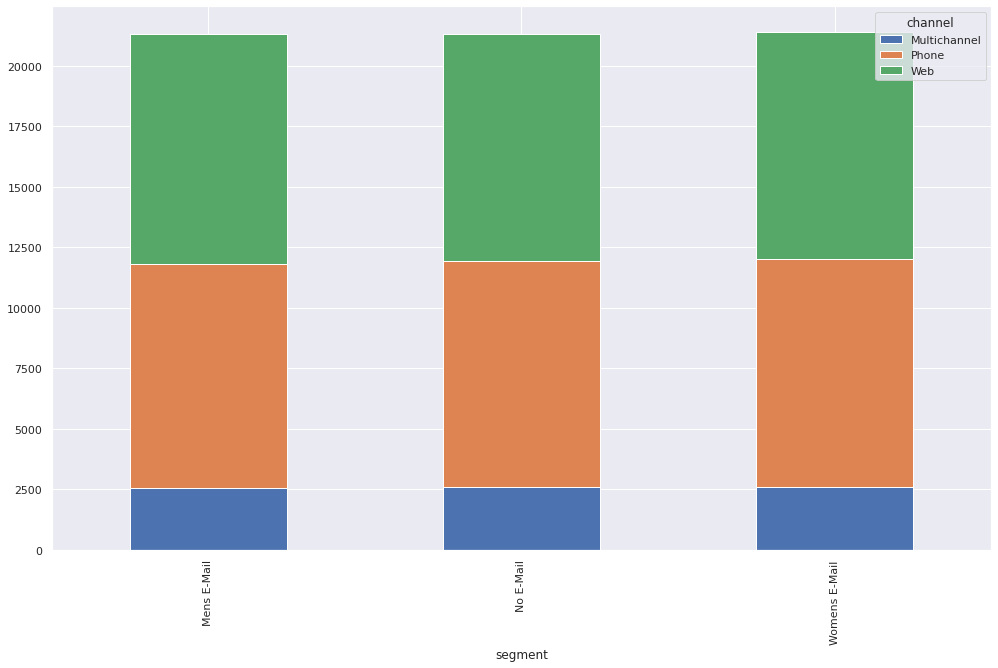

In [ ]:
segment_channel=df.groupby(['channel','segment']).size().reset_index().pivot(columns ='channel', index='segment', values=0)
segment_channel.plot(kind='bar', stacked=True);

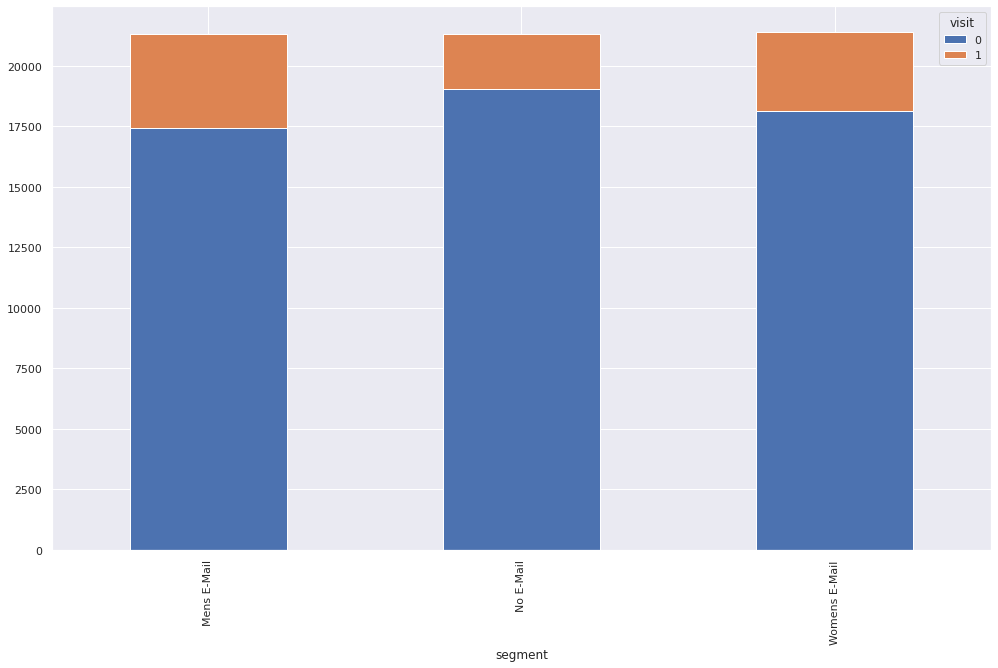

In [ ]:
segment_vist=df.groupby(['visit','segment']).size().reset_index().pivot(columns ='visit', index='segment', values=0)
segment_vist.plot(kind='bar', stacked=True);

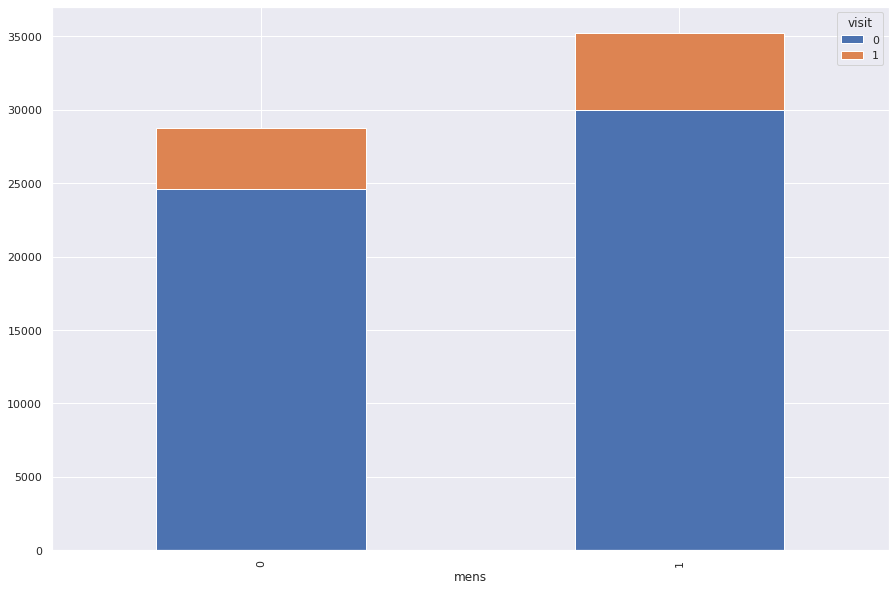

In [ ]:
mens=df.groupby(['visit','mens']).size().reset_index().pivot(columns ='visit', index='mens', values=0)

mens.plot(kind='bar', stacked=True);



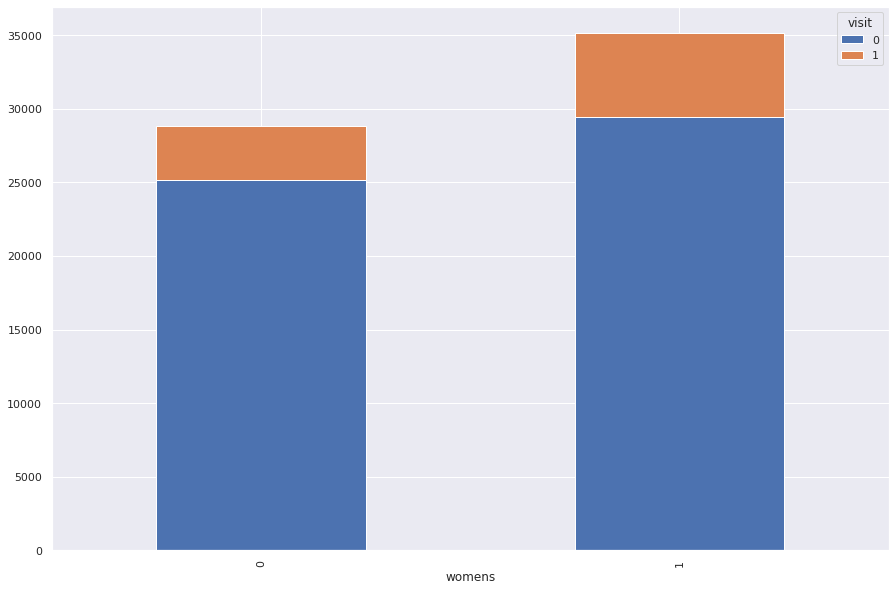

In [ ]:
womens=df.groupby(['visit','womens']).size().reset_index().pivot(columns ='visit', index='womens', values=0)
womens.plot(kind='bar', stacked=True);

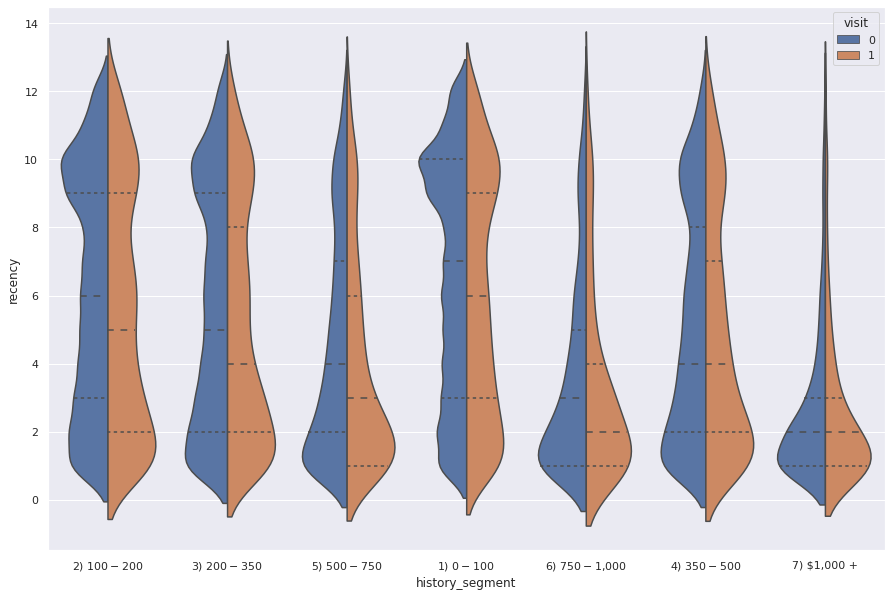

In [ ]:
plt.figure()
sns.violinplot(x='history_segment', y='recency', hue='visit',
                   split=True, inner="quart",
                   data= df, subplots=True);

 
##**Data Preparation**

In [ ]:
# Rename Columns
df=df.rename(columns={'segment':'Treatment'})

# Create dummy columns
dummy_cols= ['zip_code', 'history_segment', 'channel']
for col in dummy_cols:
  df=pd.get_dummies(df, columns=[col], prefix=col)

# Data normalization

normalization_fields=['recency','history']
df[normalization_fields]=(df[normalization_fields] - df[normalization_fields].mean())/df[normalization_fields].std()

In [ ]:
# Encode the 'Treatment' column
treatment_encoder={'No E-Mail':'0', 'Mens E-Mail': '1', 'Womens E-Mail':'2'}
df['Treatment'] = df['Treatment'].apply(lambda x: treatment_encoder[x])
df.head()

,recency,history,mens,womens,newbie,Treatment,visit,conversion,spend,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",channel_Multichannel,channel_Phone,channel_Web
0,1.207742,-0.389000,1,0,0,2,0,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,0.067358,0.339611,1,1,1,0,0,0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,0.352454,-0.239834,0,1,1,2,0,0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,0.922646,1.693265,1,0,1,1,0,0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,-1.073025,-0.768062,1,0,0,2,0,0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,1


In [ ]:
pd.crosstab(df['Treatment'],df['visit'], margins= True)

visit,0,1,All
Treatment,,,
0,19044,2262,21306
1,17413,3894,21307
2,18149,3238,21387
All,54606,9394,64000


In [ ]:
df.pivot_table(values=['visit', 'conversion','spend'],
               index = 'Treatment',
               aggfunc=[np.mean],
               margins = True)

mean                    
          conversion     spend     visit
Treatment                               
0           0.005726  0.652789  0.106167
1           0.012531  1.422617  0.182757
2           0.008837  1.077202  0.151400
All         0.009031  1.050908  0.146781

In [ ]:
# To drop the 'conversion' and 'spend' column 
df_red = df.drop(columns=["conversion", "spend"])
df_red.head()
df_red.shape

#**Application in CausalML**

Notes: Treatment group encoder in CausalML has to be as string.







 **Run the Uplift Random Forest classifier**
 
We first fit the uplift random forest classifier using training data. We then use the fitted model to make a prediction using validation data. The prediction returns an ndarray in which each column contains the predicted uplift if the unit was in the corresponding treatment group.

In [ ]:
# Split the data into training and testing samples
df_train, df_test = train_test_split(df_red, test_size = 0.3, random_state=123)
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

In [ ]:
# define X (feature)
x_names=list(df_red.drop(columns=['visit','Treatment']))
len(x_names)


In [ ]:
df_train

,recency,history,mens,womens,newbie,Treatment,visit,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",channel_Multichannel,channel_Phone,channel_Web
0,0.637550,-0.470512,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,0.922646,1.466023,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,-0.217738,-0.220432,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1
3,-1.358121,0.456531,0,1,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,1.207742,-0.399774,1,0,0,2,0,0,0,1,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44795,-1.358121,-0.269777,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1
44796,0.922646,-0.572597,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
44797,-1.358121,1.193028,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0
44798,-0.217738,0.387667,0,1,0,2,1,0,1,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
# Fit uplift model
uplift_model =UpliftRandomForestClassifier(control_name='0')
uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['Treatment'].values,
                 y = df_train['visit'].values)


In [ ]:
# Make predictions on the validation dataset

y_pred = uplift_model.predict(df_test[x_names].values, full_output=False)

# in Dataframe format
result=pd.DataFrame(y_pred, columns=uplift_model.classes_)
result

,1,2
0,0.078172,0.024102
1,0.093352,0.030142
2,0.056866,0.007428
3,0.060823,0.008350
4,0.072911,0.015372
...,...,...
19195,0.055242,0.008876
19196,0.070466,0.009590
19197,0.073945,0.082371
19198,0.081587,0.049754


As shown from the table above, in the case of multiple treatments, the uplift model predicts the uplift for each treatment. 


# **UpliftTree Visualization**

In [ ]:
# Here we use the visualization tool to visualize the first tree in our forest. 

uplift_tree = uplift_model.uplift_forest[0]
uplift_tree.fill(X=df_test[x_names].values, 
                 treatment=df_test['Treatment'].values, 
                 y=df_test['visit'].values) ;

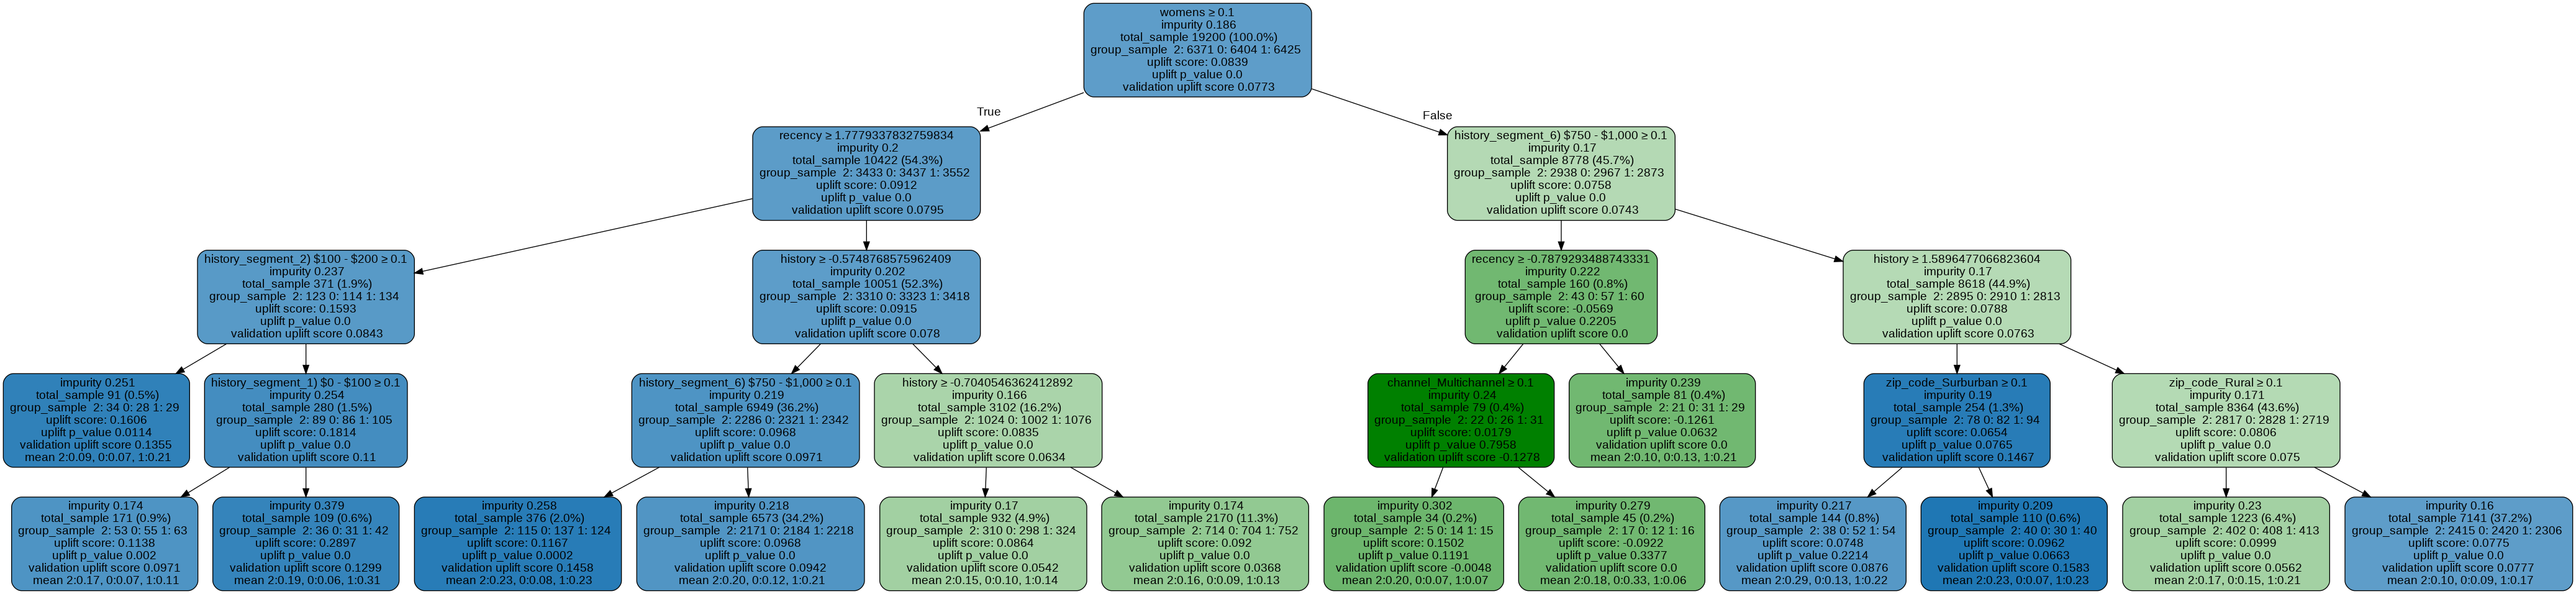

In [ ]:
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

# **Validation**

In the case of multiple treatments, we could either draw a separate uplift curve for each treatment or to combine treated subjects into one group and compare their outcomes per ranked quantile to the control group. We have applied the second option in CausalML. That is, if a customer's estimated uplift result is negative in both treatments, we would assign this person to control group. Otherwise, we would assign him/her to the treatment group with a greater effect. For example, the first individual would be assigned to Men-campaign group since the estimate showed a more effective treatment effect under Men-campaign treatment assignment. 

In [ ]:
result = result.assign(Control=0.0)

max_treatment_key=pd.DataFrame(result.idxmax(axis=1))
max_treatment_key.rename(columns={0:'max_treatment_key'}, inplace=True)
max_treatment_value= pd.DataFrame(result.max(axis=1))
max_treatment_value.rename(columns={0:'max_treatment_value'}, inplace=True)

max_treatment = pd.concat([max_treatment_key, max_treatment_value], axis=1)
max_treatment


,max_treatment_key,max_treatment_value
0,1,0.078172
1,1,0.093352
2,1,0.056866
3,1,0.060823
4,1,0.072911
...,...,...
19195,1,0.055242
19196,1,0.070466
19197,2,0.082371
19198,1,0.081587


In [ ]:
result_test = pd.concat([df_test, result, max_treatment], axis=1)
result_test = result_test.loc[:,['Treatment','visit', 
                                 '1', '2', 
                                 'max_treatment_key', 'max_treatment_value']]
result_test.head(10)

,Treatment,visit,1,2,max_treatment_key,max_treatment_value
0,1,1,0.078172,0.024102,1,0.078172
1,0,0,0.093352,0.030142,1,0.093352
2,0,0,0.056866,0.007428,1,0.056866
3,1,0,0.060823,0.008350,1,0.060823
4,2,0,0.072911,0.015372,1,0.072911
5,1,0,0.084418,0.057534,1,0.084418
6,1,1,0.085979,0.034196,1,0.085979
7,2,1,0.082338,0.016998,1,0.082338
8,2,1,0.074660,0.079885,2,0.079885
9,2,0,0.079949,0.016341,1,0.079949


In [ ]:
# add one more column treatment_indictor, 0 or 1 (back to binary treatment)
result_test['treatment_indic'] =1
result_test.loc[(result_test['Treatment'] == '0'), 'treatment_indic'] =0
result_test

,Treatment,visit,1,2,max_treatment_key,max_treatment_value,treatment_indic
0,1,1,0.078172,0.024102,1,0.078172,1
1,0,0,0.093352,0.030142,1,0.093352,0
2,0,0,0.056866,0.007428,1,0.056866,0
3,1,0,0.060823,0.008350,1,0.060823,1
4,2,0,0.072911,0.015372,1,0.072911,1
...,...,...,...,...,...,...,...
19195,2,0,0.055242,0.008876,1,0.055242,1
19196,0,0,0.070466,0.009590,1,0.070466,0
19197,2,0,0.073945,0.082371,2,0.082371,1
19198,1,0,0.081587,0.049754,1,0.081587,1


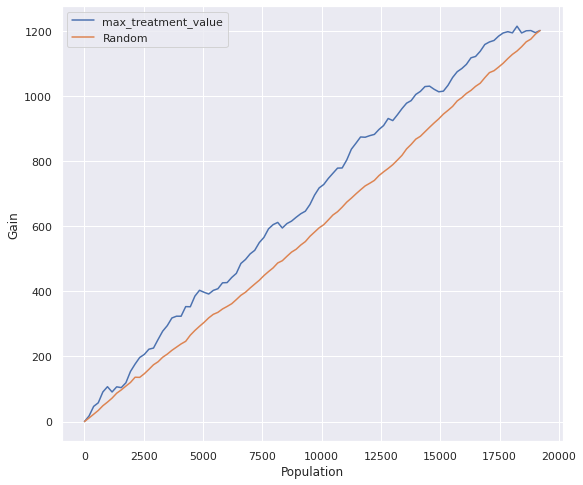

In [ ]:
plot_gain(df=result_test.loc[:,['visit','treatment_indic', 'max_treatment_value']], 
     outcome_col='visit', 
     treatment_col='treatment_indic'
    )

CausalML has the plot_gain() function which calculates the uplift curve given a DataFrame containing the treatment assignment, observed outcome and the predicted treatment effect.  

The cumulative value of Lift is calculated by comparing when assigned to the treatment group where the maximum 'lift' effect can be expected (blue) and when assigned to control group (red).  
(X-axis: sample size, Y-axis: cumulative Lift value)

# **Application in PyLift**

Notes: When encoding treatment group, cannot use string or float. 

#**Treatment and Control Group Selection**

Hillstrom dataset has 2 treatment and 1 control groups annotated respecively:


*   0, No E-Mail
*   1, Mens E-Mail
*   2, Womens E-Mail

To analysie each treatment seperatly we split the data into two subsets accordingly. Since the pylift package requires the treatment assignment to be marked with {0, 1}, the entries with value 2 for Woman E-mail have be re-labled

In [ ]:
df_2 = df.copy()
df_2['Treatment'] =df_2['Treatment'].astype('int32')
df_woman = df_2.loc[df_2['Treatment']!= 1]

In [ ]:
df_woman_copy = df_woman['Treatment'].copy() 
df_woman['Treatment'] =df_woman_copy.replace({2:1})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_woman

,recency,history,mens,womens,newbie,Treatment,visit,conversion,spend,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",channel_Multichannel,channel_Phone,channel_Web
0,1.207742,-0.389000,1,0,0,1,0,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,0.067358,0.339611,1,1,1,0,0,0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,0.352454,-0.239834,0,1,1,1,0,0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,-1.073025,-0.768062,1,0,0,1,0,0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,1
5,0.067358,-0.418708,0,1,0,1,1,0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63989,1.207742,0.242874,1,1,0,1,1,0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,1
63990,0.067358,-0.632677,0,1,0,0,0,0,0.0,0,1,0,1,0,0,0,0,0,0,0,1,0
63991,-1.358121,0.249901,1,0,1,1,0,0,0.0,0,1,0,0,0,1,0,0,0,0,0,1,0
63993,-0.502833,0.515245,0,1,0,1,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
df_men = df_2.loc[df_2['Treatment']!= 2]
df_men
#df_woman['Treatment'].unique()

,recency,history,mens,womens,newbie,Treatment,visit,conversion,spend,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",channel_Multichannel,channel_Phone,channel_Web
1,0.067358,0.339611,1,1,1,0,0,0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,0.922646,1.693265,1,0,1,1,0,0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,1
8,0.922646,1.690298,1,1,1,1,0,0,0.0,1,0,0,0,0,0,0,1,0,0,0,1,0
13,-1.073025,-0.548276,0,1,0,1,1,0,0.0,0,0,1,0,1,0,0,0,0,0,0,0,1
14,-0.502833,-0.002599,0,1,1,0,0,0,0.0,1,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63994,0.352454,-0.607536,0,1,0,1,0,0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,1
63995,1.207742,-0.533051,1,0,0,1,0,0,0.0,0,0,1,0,1,0,0,0,0,0,0,0,1
63996,-0.217738,-0.793163,0,1,1,1,0,0,0.0,0,0,1,1,0,0,0,0,0,0,0,1,0
63997,0.067358,-0.827986,1,0,1,1,0,0,0.0,0,0,1,1,0,0,0,0,0,0,0,1,0


In [ ]:
pd.crosstab(df_woman['visit'],df_woman['Treatment'], margins= True)

Treatment,0,1,All
visit,,,
0,19044,18149,37193
1,2262,3238,5500
All,21306,21387,42693


In [ ]:
pd.crosstab(df_men['visit'],df_men['Treatment'], margins= True)

Treatment,0,1,All
visit,,,
0,19044,17413,36457
1,2262,3894,6156
All,21306,21307,42613


In [ ]:
up_men = TransformedOutcome(df_men, col_treatment='Treatment', col_outcome='visit', stratify=df_men['Treatment'])

up_men.randomized_search(n_iter=20, n_jobs=10, random_state=1)

up_men.shuffle_fit(params=up_men.rand_search_.best_params_, nthread=30, iterations=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 14.5min finished


[07:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[07:19:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[07:19:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[07:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[07:20:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 4 finished.


{0: <pylift.methods.derivatives.TransformedOutcome at 0x7f3555443a90>,
 1: <pylift.methods.derivatives.TransformedOutcome at 0x7f351db12908>,
 2: <pylift.methods.derivatives.TransformedOutcome at 0x7f351c6c1080>,
 3: <pylift.methods.derivatives.TransformedOutcome at 0x7f351b3132b0>,
 4: <pylift.methods.derivatives.TransformedOutcome at 0x7f351b4a72b0>}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


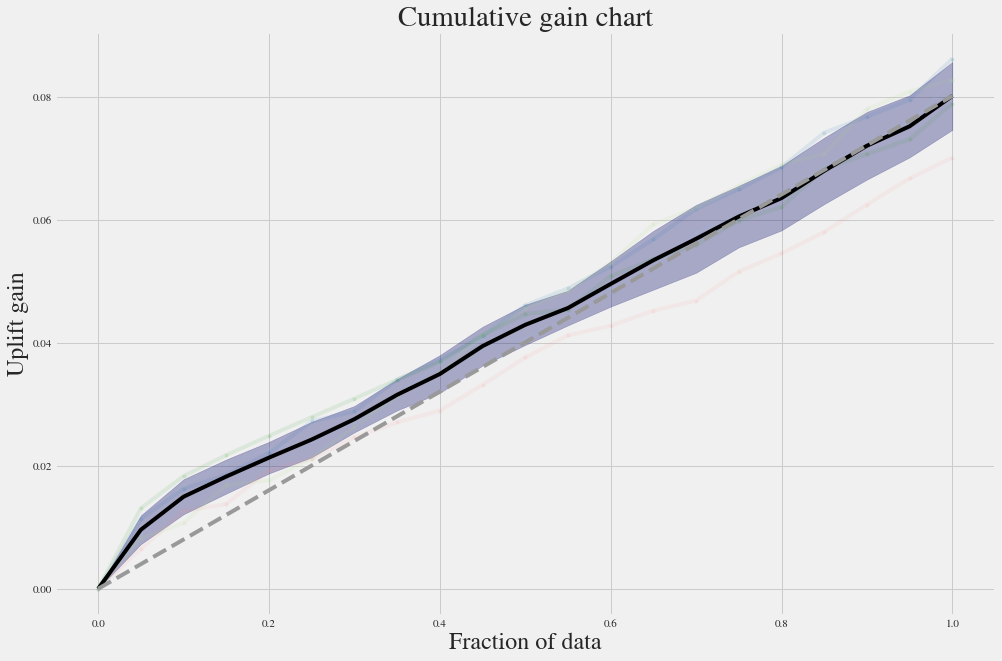

In [ ]:
up_men.plot(show_shuffle_fits=True);

In [ ]:
up_woman = TransformedOutcome(df_woman, col_treatment='Treatment', col_outcome='visit', stratify=df_woman['Treatment'])

up_woman.randomized_search(n_iter=20, n_jobs=10, random_state=1)

up_woman.shuffle_fit(params=up_men.rand_search_.best_params_, nthread=30, iterations=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 14.6min finished


[07:56:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[07:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[07:56:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[07:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[07:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 4 finished.


{0: <pylift.methods.derivatives.TransformedOutcome at 0x7f3508423a20>,
 1: <pylift.methods.derivatives.TransformedOutcome at 0x7f3508423b00>,
 2: <pylift.methods.derivatives.TransformedOutcome at 0x7f351b4475c0>,
 3: <pylift.methods.derivatives.TransformedOutcome at 0x7f350a86b2b0>,
 4: <pylift.methods.derivatives.TransformedOutcome at 0x7f35084dc358>}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


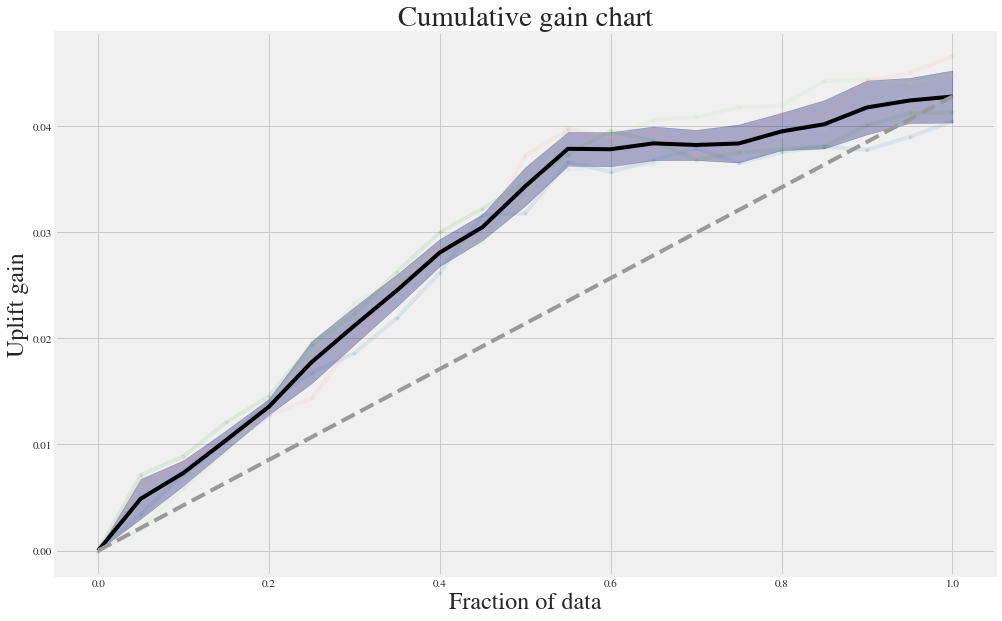

In [ ]:
up_woman.plot(show_shuffle_fits=True);


#**Interpretability of the model**

WOE and IV play two distinct roles when analyzing data:

*   WOE describes the relationship between a predictive variable and a binary target variable.
*  IV measures the strength of that relationship. (Generally, if IV<0.05 the variable has very little predictive power and will not add any meaningful predictive power to your model)



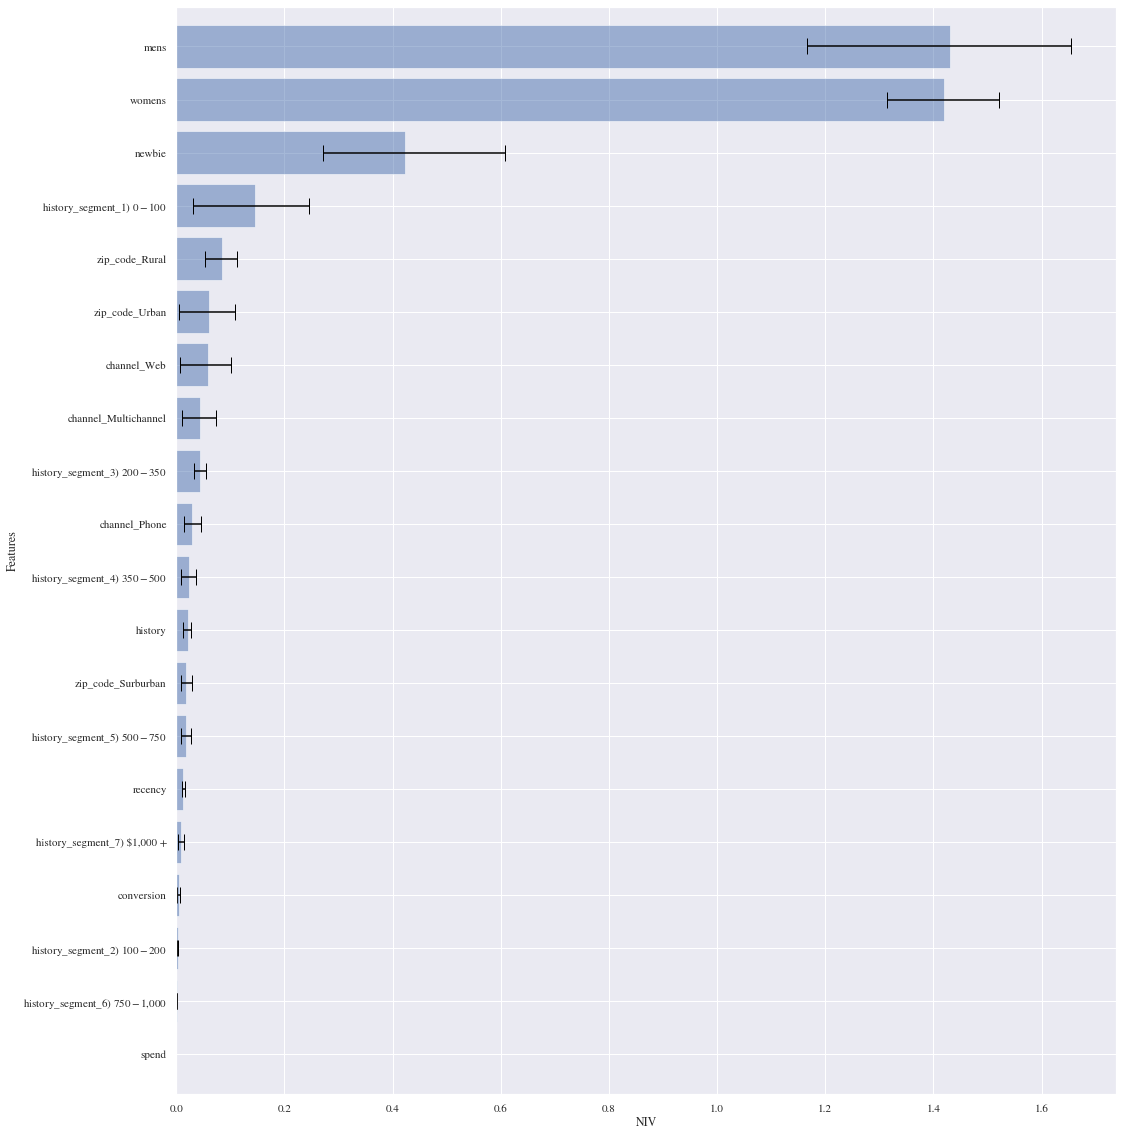

In [ ]:
up_woman.NIV()

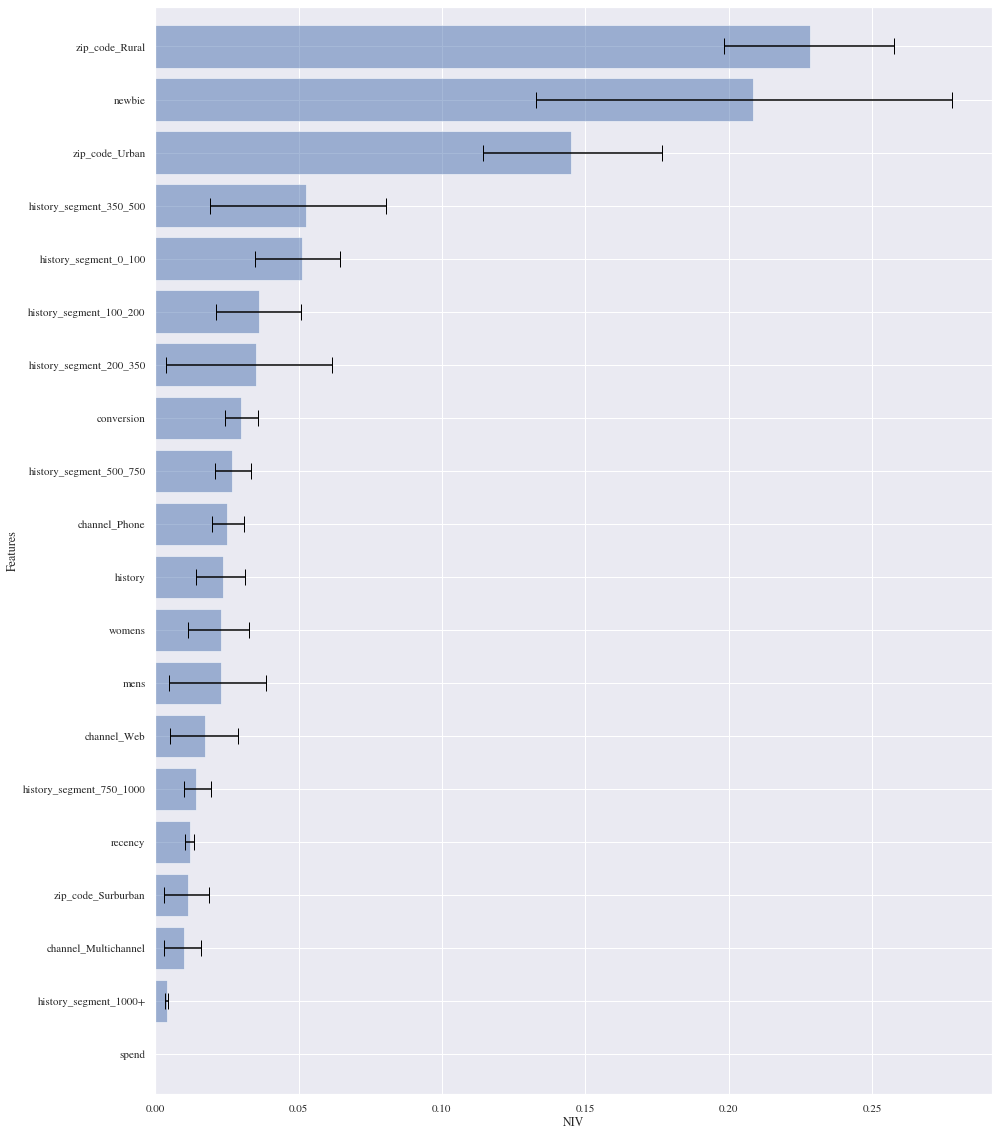

In [ ]:
up_men.NIV()

#**Application in DoWhy**

**Notes**: 1. dowhy.datasets.module, for generating sample datasets.   
2. Functionality: Refutation (used in sensitivity analysis) 
- Combine with ECONML, could test the robustness of the estimate. For example, could replace the treatment with a random(Placebo) variable or remove a random subset of the data and compare the new causal estimate with the estimated effect from the original dataset to see if the estimated effect is under the average treatment effect disitribution. 

3. Method supported: 
- Regression 
- Use propensity scores stratification
- Use propensity scores matching
- Use (inverse) propensity scores weighting
- Instrumental variable
- Combind use with more advanced methods from ECONML or CausalML

     

##**Women Campaign**  

We use Women campaign as example 

In [ ]:
# For women campaign
# Define Estimator inputs

T = df_woman['Treatment']
Y = df_woman['visit']
X_women = df_woman.drop(columns=['visit','Treatment','conversion','spend'])  # Features

In [ ]:
# Create  Causal Model and Identify Causal Effect with Dowhy

feature_names = X_women.columns.tolist()

### Step1: Model problem as a causal graph

In [ ]:
model_women = CausalModel(
    data=df_woman, 
    treatment='Treatment', 
    outcome='visit', 
    common_causes=feature_names,
    effect_modifiers=feature_names
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Treatment'] on outcome ['visit']


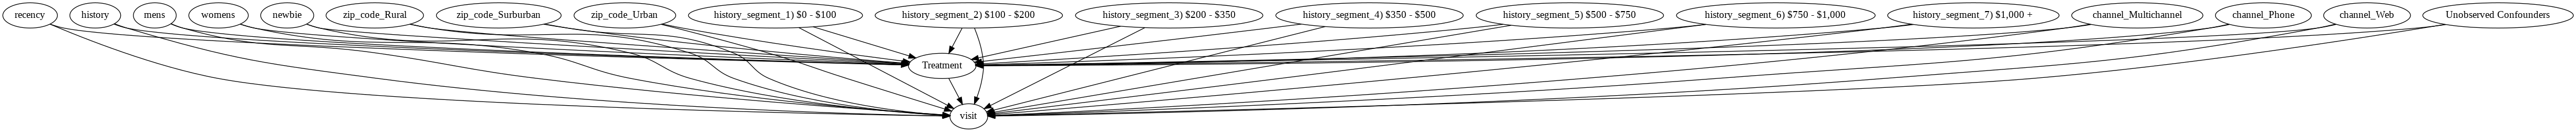

In [ ]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(model_women._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    model_women.view_model()

### Step2: Identify causal effect using properties of the formal causal graph.

In [ ]:



identified_estimand = model_women.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['history_segment_1) $0 - $100', 'history_segment_6) $750 - $1,000', 'channel_Multichannel', 'mens', 'history_segment_3) $200 - $350', 'channel_Web', 'zip_code_Urban', 'U', 'womens', 'zip_code_Rural', 'history_segment_5) $500 - $750', 'history_segment_7) $1,000 +', 'history_segment_4) $350 - $500', 'channel_Phone', 'newbie', 'recency', 'history', 'history_segment_2) $100 - $200', 'zip_code_Surburban']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(visit|history_segment_1) $0 - $100,history_segment_6)
d[Treatment]                                                                  

                                                                              
 $750 - $1,000,channel_Multichannel,mens,history_segment_3) $200 - $350,channe
                                                                              

                                                                              
l_Web,zip_code_Urban,womens,zip_code_Rural,history_segment_5) $500 - $750,hist
                                                                              

                                                                              
ory_segment_7) $1,000 +,history_segment_4) $350 - $500,channel_Phone,newbie,re
                                 

### Step3: Estimate the causal effect

- use any statistical method to estimate the causal effect. The library does not play a role here


`

In [ ]:
linear_estimate = model_women.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1,
                                       method_params={'need_conditional_estimates': False})
print(linear_estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: visit~Treatment+history_segment_1) $0 - $100+history_segment_6) $750 - $1,000+channel_Multichannel+mens+history_segment_3) $200 - $350+channel_Web+zip_code_Urban+womens+zip_code_Rural+history_segment_5) $500 - $750+history_segment_7) $1,000 ++history_segment_4) $350 - $500+channel_Phone+newbie+recency+history+history_segment_2) $100 - $200+zip_code_Surburban+Treatment*recency+Treatment*history+Treatment*mens+Treatment*womens+Treatment*newbie+Treatment*zip_code_Rural+Treatment*zip_code_Surburban+Treatment*zip_code_Urban+Treatment*history_segment_1) $0 - $100+Treatment*history_segment_2) $100 - $200+Treatment*history_segment_3) $200 - $350+Treatment*history_segment_4) $350 - $500+Treatment*history_segment_5) $500 - $750+Treatment*history_segment_6) $750 - $1,000+Treatment*history_segment_7) $1,000 ++Treatment*channel_Multichannel+Treatment*channel_Phone+Treatment*channel_Web


                            OLS Regression Results                            
Dep. Variable:                  visit   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     47.17
Date:                Sat, 01 Aug 2020   Prob (F-statistic):          3.66e-283
Time:                        17:57:50   Log-Likelihood:                -13170.
No. Observations:               42693   AIC:                         2.640e+04
Df Residuals:                   42661   BIC:                         2.668e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.588e+10   4.13e+10      0.626      0.5


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(visit|history_segment_1) $0 - $100,history_segment_6)
d[Treatment]                                                                  

                                                                              
 $750 - $1,000,channel_Multichannel,mens,history_segment_3) $200 - $350,channe
                                                                              

                                                                              
l_Web,zip_code_Urban,womens,zip_code_Rural,history_segment_5) $500 - $750,hist
                                                                              

                                                                              
ory_segment_7) $1,000 +,history_segment_4) $350 - $500,channel_P

###Step 4: Refute: Senstivity analysis 
* We could continue on to refute the obtained estimate: adding random common cause variable, replace treatment with placebo variable, remove a random subset etc. Considering the space limit, we left out this step here, but include to show the complete work flow of DoWhy. 